In [2]:
import numpy as np
import os
import math
from PIL import Image
import pandas as pd

# Clustering
from sklearn.cluster import AgglomerativeClustering # 1) Agglomerative-Hierarchical
from sklearn.cluster import KMeans                  # 2) K-Means
from sklearn.mixture import GaussianMixture         # 3) Gaussian Mixture Models

from skimage.color import rgb2hed
from sklearn.preprocessing import StandardScaler

# Evaluation
from sklearn import metrics
from skimage.external import tifffile
from skimage.measure import compare_mse
# from skimage.metrics import structural_similarity as ssim

from sklearn.decomposition import PCA, KernelPCA               # 2) PCA
from sklearn.manifold import TSNE

# Load Autoencoder                                  # 3) Autoencoder (Deep dimensionality reduction)
from keras.models import load_model
from keras.models import Model

import cv2

import matplotlib.pyplot as plt 
%matplotlib inline

import newscripts as myutils

Using TensorFlow backend.
c:\users\mostafaosama2\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\mostafaosama2\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\mostafaosama2\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dt

In [7]:
## Data loading

# directory = "../../Data/train"
# directory = "../../Data/Kather_all"
directory = "C:/Users/mostafaosama2/Desktop/kather_all"

new_train = []
image_names = []

# Test on 1000 images
for filename in os.listdir(directory):
    if filename.endswith('.tif'):
        image = cv2.imread(os.path.join(directory, filename), cv2.IMREAD_UNCHANGED)
        resized_image = cv2.resize(image, (96, 96)) 
        new_train.append(np.asarray( resized_image, dtype="uint8" ))
        image_names.append(filename)
        
# labels_true = myutils.loadLabelsFromsubdirectoryindex(image_names, "../../Data/Kather_5000")
labels_true = myutils.loadLabelsFromsubdirectoryindex(image_names, "C:/Users/mostafaosama2/Desktop/autoenctrain/kather_labels")

In [5]:
# autoencoder = load_model('../Autoencoders/SavedModels/fulldata_checkpoint_epochs10000_batch32_adam.h5') # 6 x 6 x 16
autoencoder = load_model('C:/Users/mostafaosama2/Desktop/PathologyFinal/Autoencoders/feb_epochs1000_batch32_adam.h5') # 6 x 6 x 16
layer_name = 'conv2d_7' # 6 x 6 x 16
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(layer_name).output)

# autoencoder.summary()

In [8]:
meanMatrix = np.asarray(new_train)
meanMatrix = meanMatrix.astype('float32') / 255. # Normalize the values before predictions
X = encoder.predict(meanMatrix)
print(X.shape)

MemoryError: Unable to allocate array with shape (5000, 96, 96, 3) and data type float32

(5000, 576)
HC Silhouette Score  0.2036329060792923 
kmeans Silhouette Score  0.2188563048839569 
gmm Silhouette Score  0.20761342346668243 


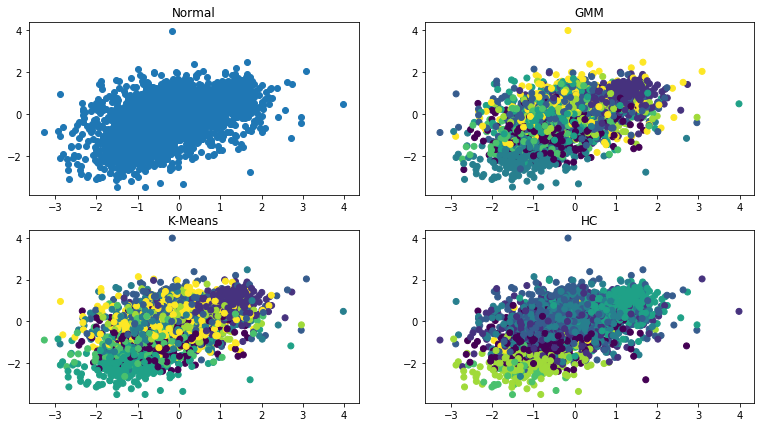

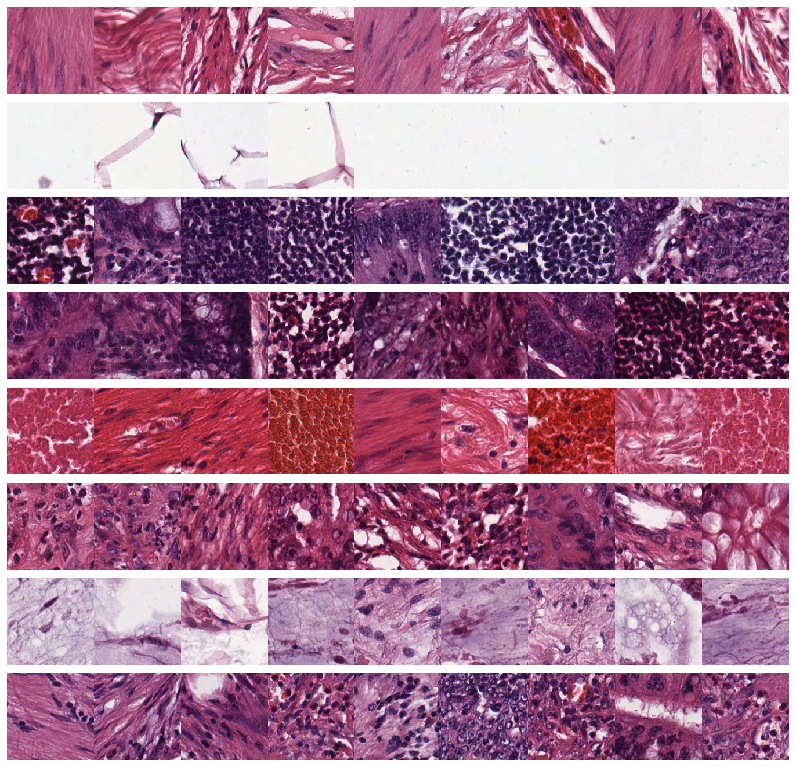

In [5]:
X = X.reshape(X.shape[0] , -1) # Reshape for scaling
X = StandardScaler().fit_transform(X) # Scale

Labels = myutils.ClusterAndPlot(8, X)
myutils.clusterintoDirectories(Labels[1], directory, image_names)
myutils.pltPathologyClusters(Labels[1], directory)

In [6]:
myutils.evaluateAll3withLabels(Labels, labels_true)

KMeans Adjusted Rand index 0.5238803034523238
KMeans homogeneity_score 0.5133653781554193
KMeans adjusted_rand_score 0.3953964036092753
KMeans completeness_score 0.5372400342647455
KMeans v_measure_score 0.5220654935579553


In [12]:
# PCA 
print(X.shape)
pca = PCA(n_components=0.95)
transformedData = pca.fit_transform(X)
pca.n_components_

(5000, 576)


173

(5000, 173)
HC Silhouette Score  0.056286558508872986 
kmeans Silhouette Score  0.23192258179187775 
gmm Silhouette Score  0.1550472229719162 


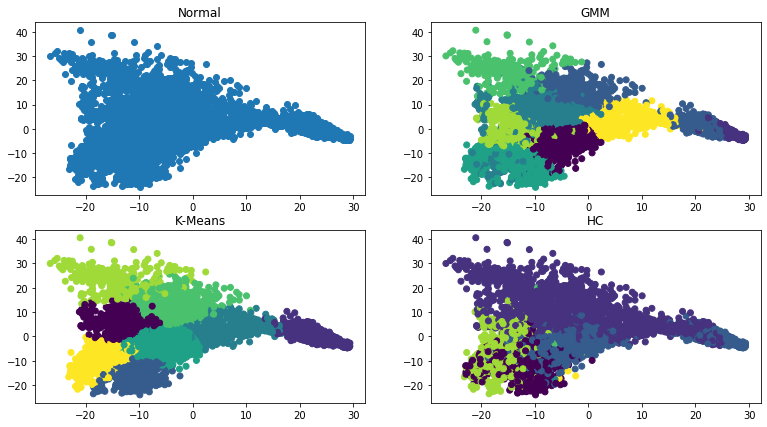

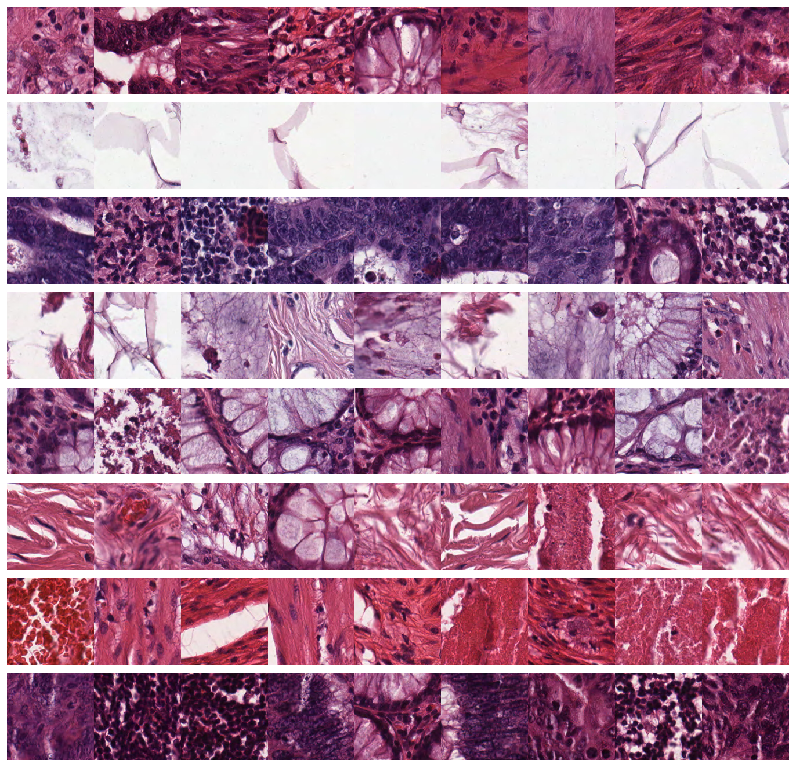

In [13]:
Labels = myutils.ClusterAndPlot(8, transformedData)
myutils.clusterintoDirectories(Labels[1], directory, image_names)
myutils.pltPathologyClusters(Labels[1], directory)

In [14]:
myutils.evaluateAll3withLabels(Labels, labels_true)

KMeans Adjusted Rand index 0.5232119139520433
KMeans homogeneity_score 0.5125530509403005
KMeans adjusted_rand_score 0.39457697408873404
KMeans completeness_score 0.536734282384901
KMeans v_measure_score 0.5213612907327019


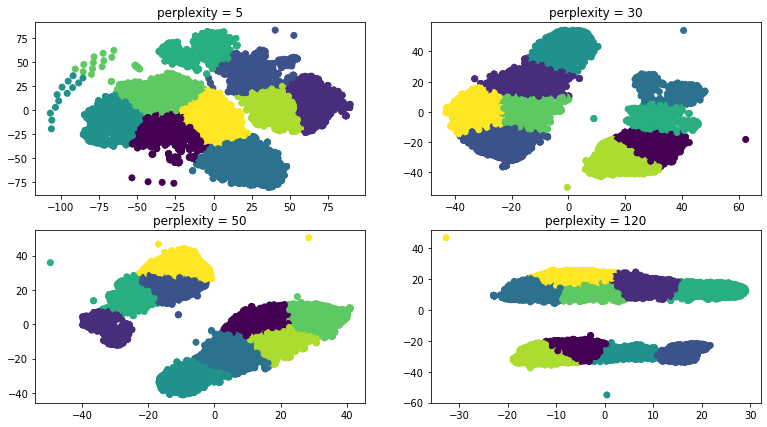

In [24]:
myutils.plotdiffTsne(transformedData)

Silhouette Score  0.32577070593833923 
Silhouette Score  0.40464913845062256 
Silhouette Score  0.24618087708950043 
Silhouette Score  0.3942194879055023 


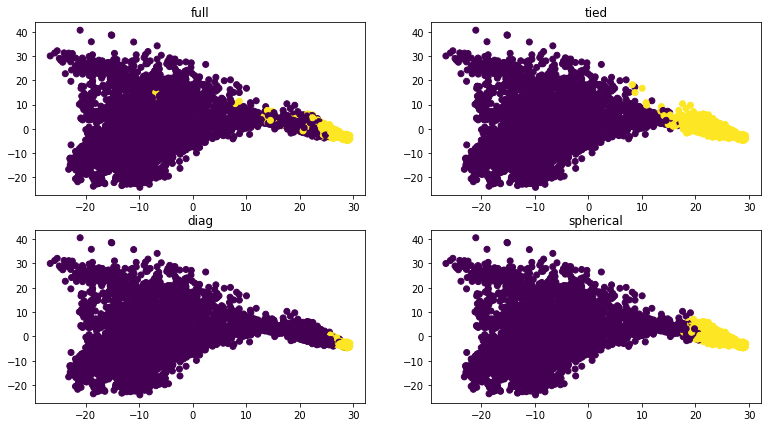

In [15]:
plotdiffGaussians(n_clusters=8, transformedData)

Silhouette Score  0.24176287651062012 
Silhouette Score  0.11372072249650955 
Silhouette Score  0.39288491010665894 
Silhouette Score  0.21448367834091187 


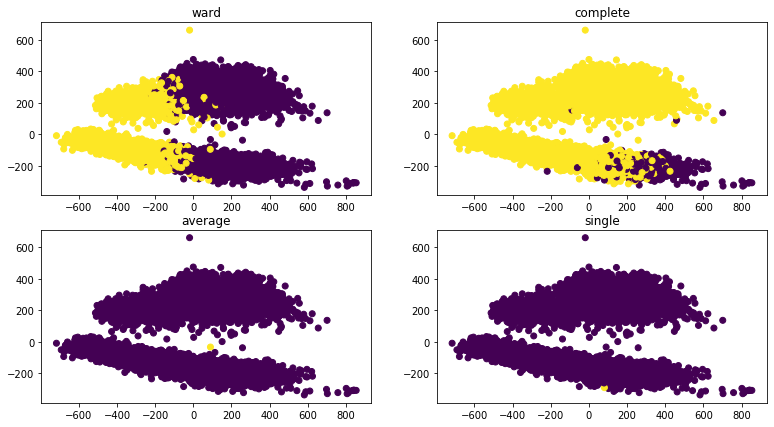

In [18]:
plotdiffHCs(n_clusters=8, transformedData)